In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Brain Tumor MRI Dataset

/content/drive/MyDrive/Brain Tumor MRI Dataset


In [ ]:
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
vgg_tuning = load_model('/content/drive/MyDrive/Brain Tumor MRI Dataset/model.vgg_tuning.h5')

# Define image size
IMG_SIZE = (224, 224)

# Load and preprocess a single image for testing
img_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/glioma/Tr-glTr_0000.jpg'
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Create ImageDataGenerator for data augmentation
datagen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
augmented_images = []
for batch in datagen.flow(img_array, batch_size=1):
    augmented_images.append(batch)
    if len(augmented_images) >= 5:  # Generate 5 augmented images
        break

1/1 [==============================] - 0s 21ms/step


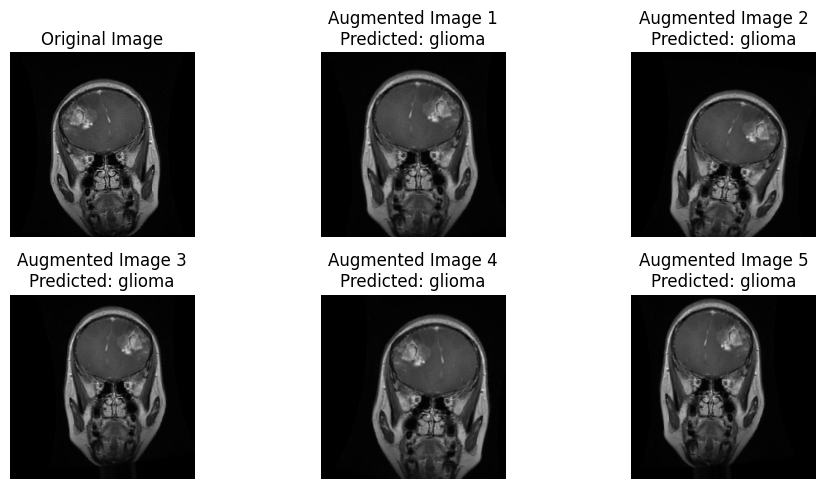

In [ ]:
import matplotlib.pyplot as plt

# Define the class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Plot the augmented images and their predictions
for i, augmented_img in enumerate(augmented_images):
    plt.subplot(2, 3, i+2)
    plt.imshow(np.squeeze(augmented_img))
    predictions = vgg_tuning.predict(augmented_img)
    predicted_label = class_labels[np.argmax(predictions)]
    plt.title(f'Augmented Image {i+1}\nPredicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Define data augmentation for training
train_datagen = ImageDataGenerator(
    rescale = None,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function= preprocess_input
)

# For testing, we just preprocess
test_val_datagen = ImageDataGenerator(rescale = None, preprocessing_function= preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain Tumor MRI Dataset/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle= True,
    seed=42
)


test_generator = test_val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# images after preprocess

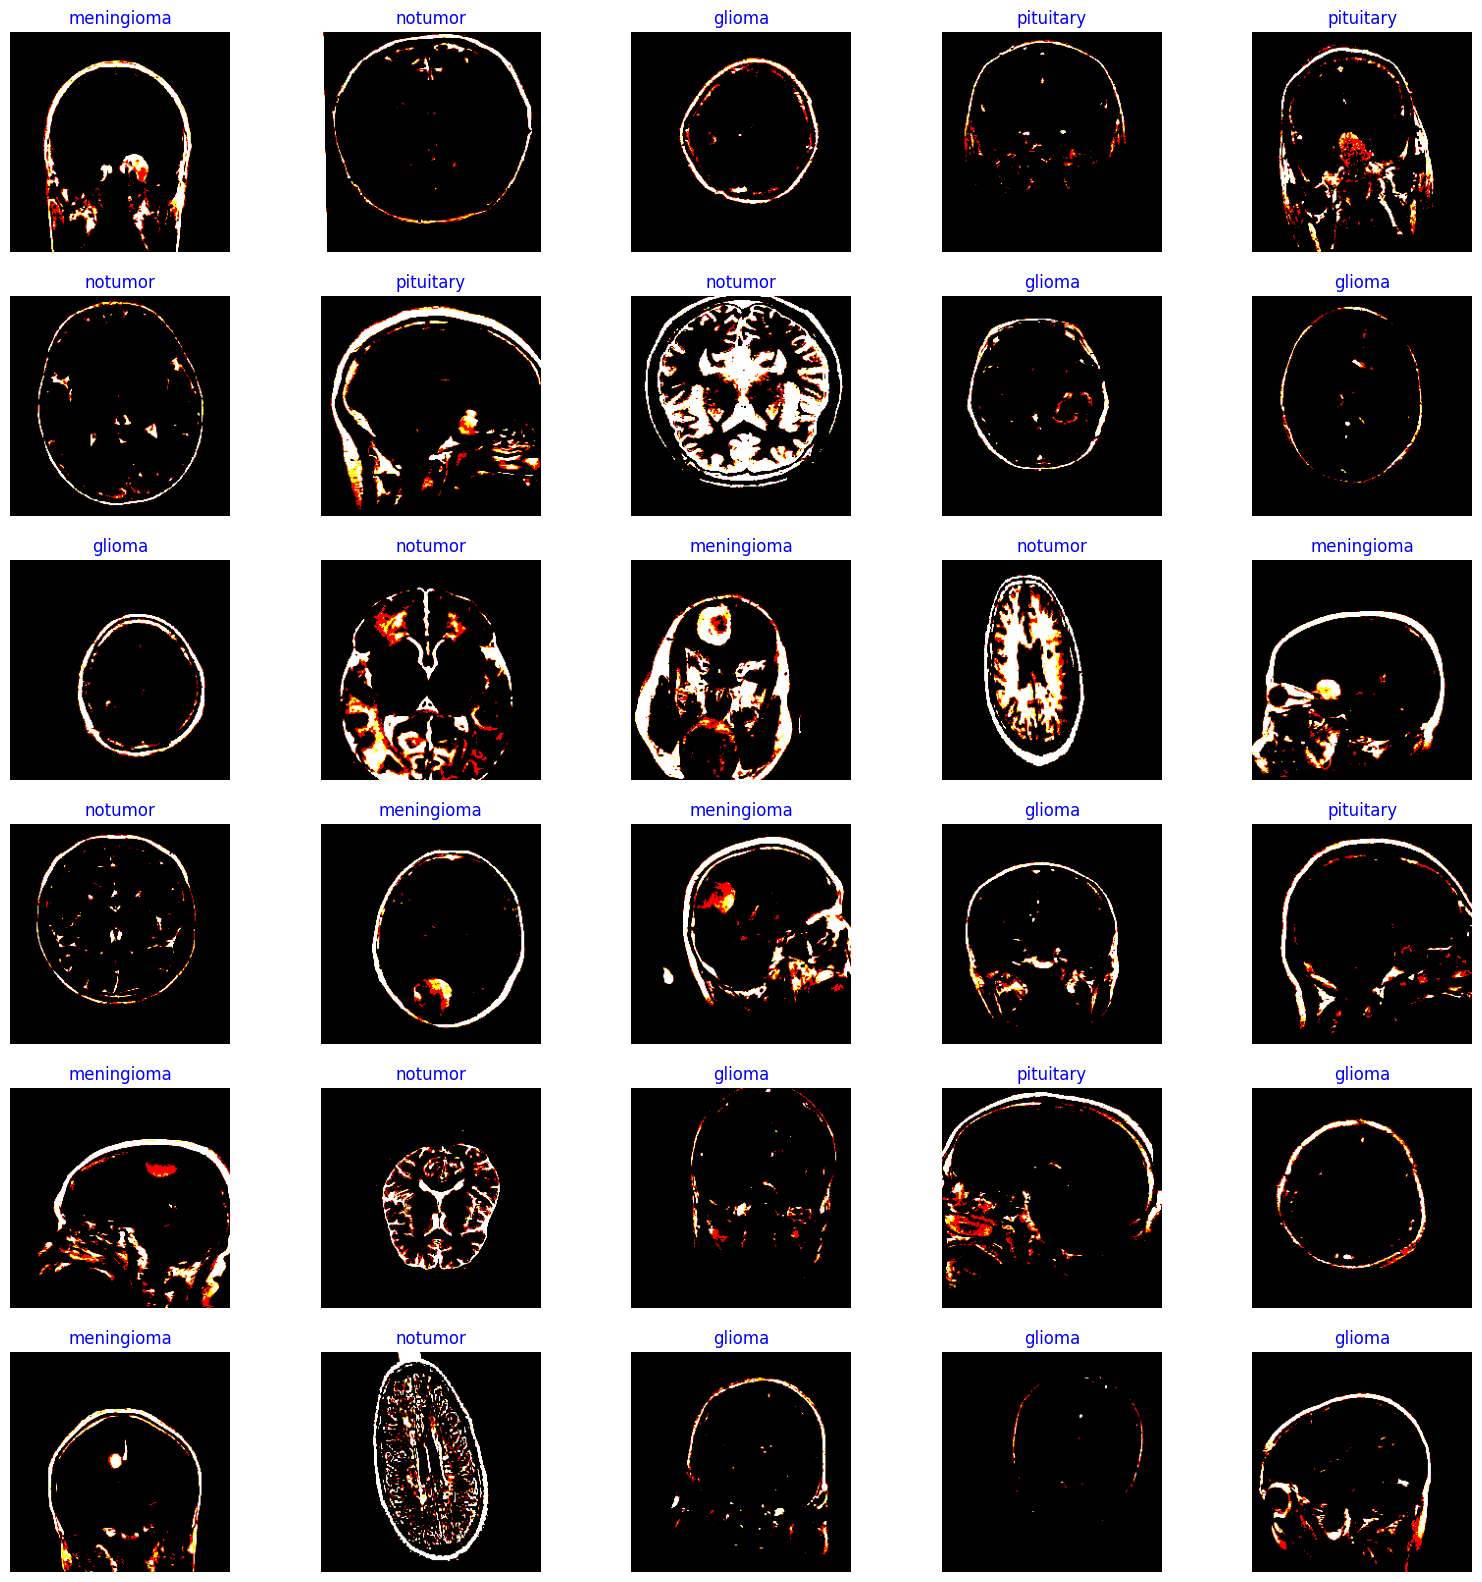

In [ ]:
class_names = list(train_generator.class_indices.keys())

def plot_images():
        images, labels = next(train_generator)

        fig, axes = plt.subplots(6, 5, figsize=(20, 20))
        axes = axes.ravel()
        for i in np.arange(0, 30):
            axes[i].imshow(images[i])
            axes[i].set_title(class_names[np.argmax(labels[i])], color='b')
            axes[i].axis('off')

        plt.subplots_adjust(wspace=0.01)
        plt.show()

plot_images()

In [ ]:
# Hyperparameters
from tensorflow.keras.optimizers import legacy

IMG_SHAPE = IMG_SIZE + (3,)
LOSS = keras.losses.CategoricalCrossentropy()
OPTIMIZER = legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
SEED = 42
# callbacks for the models
def get_callbacks (model_name):
  callbacks = []
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= f'model.{model_name}.h5', monitor = 'val_loss', verbose = 1 ,
                                                    mode = 'min', save_best_only=True, save_freq='epoch')
  callbacks.append(checkpoint)
  rlr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.2, patience=5, mode='auto', min_lr=0.0)
  callbacks.append(rlr)
  earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7)
  callbacks.append(earlystop)

  return callbacks

def plot():
   pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy','loss','val_loss']].plot( figsize=(7, 5), xlim=[0, 19], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
   plt.show()


In [10]:
callbacks = get_callbacks('Data_augmentation')

history = vgg_tuning.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=callbacks
)

Epoch 1/20
179/179 [==============================] - ETA: 0s - loss: 0.0958 - categorical_accuracy: 0.9671
Epoch 1: val_loss improved from inf to 0.08144, saving model to model.Data_augmentation.h5
179/179 [==============================] - 1422s 8s/step - loss: 0.0958 - categorical_accuracy: 0.9671 - val_loss: 0.0814 - val_categorical_accuracy: 0.9733 - lr: 2.0000e-04
Epoch 2/20
179/179 [==============================] - ETA: 0s - loss: 0.0616 - categorical_accuracy: 0.9809
Epoch 2: val_loss did not improve from 0.08144
179/179 [==============================] - 119s 663ms/step - loss: 0.0616 - categorical_accuracy: 0.9809 - val_loss: 0.0853 - val_categorical_accuracy: 0.9741 - lr: 2.0000e-04
Epoch 3/20
179/179 [==============================] - ETA: 0s - loss: 0.0416 - categorical_accuracy: 0.9855
Epoch 3: val_loss improved from 0.08144 to 0.05506, saving model to model.Data_augmentation.h5
179/179 [==============================] - 121s 678ms/step - loss: 0.0416 - categorical_accur

<div class= "alert alert-block alert-info">
    <b>   The final accuracy is"0.988" and final loss "0.034"  </b>
</div>


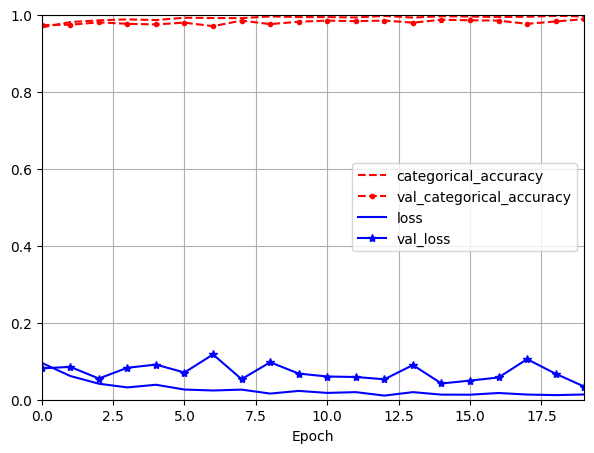

In [11]:
plot()

Here there is all the models trained: https://drive.google.com/drive/folders/1B6amPzGYuBScGl2G3ph1uH5U66CTfPrZ
